### Imports

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import ijson
import pandas as pd
import json
import numpy as np
import glob
from ast import literal_eval
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from itertools import tee
from collections import defaultdict
import plotly.graph_objects as go
import networkx as nx
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from itertools import tee
from collections import defaultdict
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

### Data Processing

In [28]:
# Find all chunk files (assuming they follow a consistent naming pattern)
file_paths = glob.glob('../datasets/2025_csv/_chunk_*.csv')
# Read each file (limiting rows if necessary) and concatenate
dfs = [pd.read_csv(fp, nrows=10000) for fp in file_paths]
df = pd.concat(dfs, ignore_index=True)

# Printing the original columns
print("Dataset columns:")
print(df.columns)
# print(df.head)

Dataset columns:
Index(['$insert_id', 'amplitude_id', 'app', 'city', 'client_event_time',
       'client_upload_time', 'country', 'data', 'data_type', 'device_family',
       'device_id', 'device_type', 'dma', 'event_id', 'event_properties',
       'event_time', 'event_type', 'language', 'library', 'os_name',
       'os_version', 'platform', 'processed_time', 'region',
       'server_received_time', 'server_upload_time', 'session_id', 'user_id',
       'user_properties', 'uuid'],
      dtype='object')


In [29]:
# Code checks which columns may have nested JSON data
print("Columns with potential JSON data:")
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            sample = df[col].dropna().iloc[0]
            if sample.startswith('{') or sample.startswith('['):
                print(f"- {col} (Possible JSON)")
        except Exception:
            pass

Columns with potential JSON data:
- data (Possible JSON)
- event_properties (Possible JSON)
- user_properties (Possible JSON)


In [30]:
# Ensure each value is a dictionary
# Determine the union of all keys
# Create new columns for each key
# Drop the original nested JSON columns
def ensure_dict(x):
    if isinstance(x, dict):
        return x
    try:
        # String representation of a dict turned into dictionary object
        return literal_eval(x)
    except Exception:
        # If parsing fails, return an empty dict
        return {}

In [31]:
# List of nested columns to process
nested_columns = ['data', 'event_properties', 'user_properties']

# Process each nested column
# ONLY RUN THIS ONCE!
for col in nested_columns:
    # Ensure each value in the column is a dictionary
    df[col] = df[col].apply(ensure_dict)
    
    # Determine the union of all keys in the column
    all_keys = set()
    df[col].dropna().apply(lambda d: all_keys.update(d.keys()) if isinstance(d, dict) else None)
    
    # For each key, create a new column only if it has at least one valid (non-empty) value
    for key in all_keys:
        new_col_name = f"{col}_{key}"
        # Create a temporary Series for this key
        series = df[col].apply(lambda d: d.get(key, None) if isinstance(d, dict) else None)
        # Check if there's at least one valid value (not None, {}, [], or 'EMPTY')
        if series.apply(lambda v: v not in (None, {}, [], 'EMPTY')).any():
            df[new_col_name] = series
    
    # After processing, drop the original nested JSON column.
    df.drop(columns=[col], inplace=True)

# Convert specified timestamp columns to datetime objects
time_cols = ['client_event_time', 'event_time', 'server_received_time']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [32]:
# Printing the columns (new additional ones added from flattening nested columns)
print("Dataset columns:")
print(df.columns)
print("# of columns:", len(df.columns))

Dataset columns:
Index(['$insert_id', 'amplitude_id', 'app', 'city', 'client_event_time',
       'client_upload_time', 'country', 'data_type', 'device_family',
       'device_id', 'device_type', 'dma', 'event_id', 'event_time',
       'event_type', 'language', 'library', 'os_name', 'os_version',
       'platform', 'processed_time', 'region', 'server_received_time',
       'server_upload_time', 'session_id', 'user_id', 'uuid',
       'data_user_properties_updated', 'data_path',
       'event_properties_attachmentId', 'event_properties_status',
       'event_properties_rowModel',
       'event_properties_[Amplitude] Session Replay ID',
       'event_properties_formId', 'event_properties_id',
       'event_properties_filename', 'event_properties_messageId',
       'event_properties_slug', 'event_properties_accountId',
       'event_properties_tableId', 'event_properties_hasAccounts',
       'event_properties_action', 'event_properties_menu',
       'event_properties_internalEmailId', 'eve

In [33]:
# Single example looks like:
# Display entire column content without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(df.iloc[140].to_string())

$insert_id                                        c1d05ff4-d1cb-48ee-b4a4-d15c42906116
amplitude_id                                                              857540771367
app                                                                             591532
city                                                                           Detroit
client_event_time                                           2025-01-16 13:06:26.842000
client_upload_time                                          2025-01-16 13:06:27.495000
country                                                                  United States
data_type                                                                        event
device_family                                                                  Windows
device_id                                         7448ddbc-a304-4f4c-9c1e-0e7b0adf93ff
device_type                                                                    Windows
dma                                        

In [34]:
# What does atleast a single valid entry look like?
# Dictionary to store a valid value for each column
valid_entries = {}
# Iterate over each column in the DataFrame
for col in df.columns:
    # Iterate over each row value for this column using .items()
    for idx, value in df[col].items():
        # Check if the value is not empty (None, empty dict, empty list, or 'EMPTY')
        if value not in (None, {}, [], 'EMPTY'):
            # Once a valid value is found, record it and its type, then break out of the loop for this column
            valid_entries[col] = (value, type(value))
            break

# Print the results
for col, (value, dtype) in valid_entries.items():
    print(f"Column: {col}\n  Value: {value}\n  Type: {dtype}\n")
print(len(valid_entries))

Column: $insert_id
  Value: 538ab3f8-09df-4750-90e0-abe8ad8f6a0c
  Type: <class 'str'>

Column: amplitude_id
  Value: 857540493886
  Type: <class 'int'>

Column: app
  Value: 591532
  Type: <class 'int'>

Column: city
  Value: Mumbai
  Type: <class 'str'>

Column: client_event_time
  Value: 2025-01-16 13:28:02.427000
  Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

Column: client_upload_time
  Value: 2025-01-16 13:28:04.133000
  Type: <class 'str'>

Column: country
  Value: India
  Type: <class 'str'>

Column: data_type
  Value: event
  Type: <class 'str'>

Column: device_family
  Value: Windows
  Type: <class 'str'>

Column: device_id
  Value: a798db5f-d66a-468c-8e51-4f1412853e4d
  Type: <class 'str'>

Column: device_type
  Value: Windows
  Type: <class 'str'>

Column: dma
  Value: None
  Type: <class 'str'>

Column: event_id
  Value: 6156
  Type: <class 'int'>

Column: event_time
  Value: 2025-01-16 13:28:02.427000
  Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

In [35]:
# Check that we dont have columns with zero valid pieces of data
# First, determine the columns with valid data (as already stored in valid_entries)
valid_columns = set(valid_entries.keys())
# Get all DataFrame columns
all_columns = set(df.columns)
# Determine columns that did not yield any valid entry
invalid_columns = all_columns - valid_columns
print("Total number of columns in df:", len(df.columns))
print("Number of columns with at least one valid entry:", len(valid_columns))
print("Number of columns with NO valid data:", len(invalid_columns))
print("Columns with no valid data:")
for col in invalid_columns:
    print("  -", col)


Total number of columns in df: 67
Number of columns with at least one valid entry: 67
Number of columns with NO valid data: 0
Columns with no valid data:


In [36]:
df.columns

Index(['$insert_id', 'amplitude_id', 'app', 'city', 'client_event_time',
       'client_upload_time', 'country', 'data_type', 'device_family',
       'device_id', 'device_type', 'dma', 'event_id', 'event_time',
       'event_type', 'language', 'library', 'os_name', 'os_version',
       'platform', 'processed_time', 'region', 'server_received_time',
       'server_upload_time', 'session_id', 'user_id', 'uuid',
       'data_user_properties_updated', 'data_path',
       'event_properties_attachmentId', 'event_properties_status',
       'event_properties_rowModel',
       'event_properties_[Amplitude] Session Replay ID',
       'event_properties_formId', 'event_properties_id',
       'event_properties_filename', 'event_properties_messageId',
       'event_properties_slug', 'event_properties_accountId',
       'event_properties_tableId', 'event_properties_hasAccounts',
       'event_properties_action', 'event_properties_menu',
       'event_properties_internalEmailId', 'event_properties_acc

### General Statistics

In [37]:
# Remove rows where either 'user_id' or 'event_time' is missing and make a copy of the DataFrame.
processed_data = df.dropna(subset=['user_id', 'event_time']).copy()
# For the 'country' column, replace any missing values (NaN) with the string 'unknown'
processed_data.loc[:, 'country'] = processed_data['country'].fillna('unknown')
# Similarly, for the 'device_type' column, replace missing values with 'unknown'
processed_data.loc[:, 'device_type'] = processed_data['device_type'].fillna('unknown')
# Convert the 'event_time' column to a datetime object
processed_data.loc[:, 'event_time'] = pd.to_datetime(processed_data['event_time'])
# Sort the DataFrame by 'user_id' and then by 'event_time'
# This ensures that events for each user are in chronological order
# The index is then reset to have a clean, continuous index
processed_data = processed_data.sort_values(by=['user_id', 'event_time']).reset_index(drop=True)
# For each session, shift the 'event_time' column up by one row to get the time of the next event
# This creates a new column 'next_event_time' that holds the subsequent event time for each session
processed_data.loc[:, 'next_event_time'] = processed_data.groupby('session_id')['event_time'].shift(-1)
# Calculate the session duration by taking the difference between 'next_event_time' and the current 'event_time'
# Convert the time difference into total seconds
# This gives a numeric measure of how long each event lasted until the next event
processed_data.loc[:, 'session_duration'] = (processed_data['next_event_time'] - processed_data['event_time']).dt.total_seconds()

/var/folders/n3/0y_s6gj10txcrg0j0zz2rmpc0000gn/T/ipykernel_35674/3318560403.py:8: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



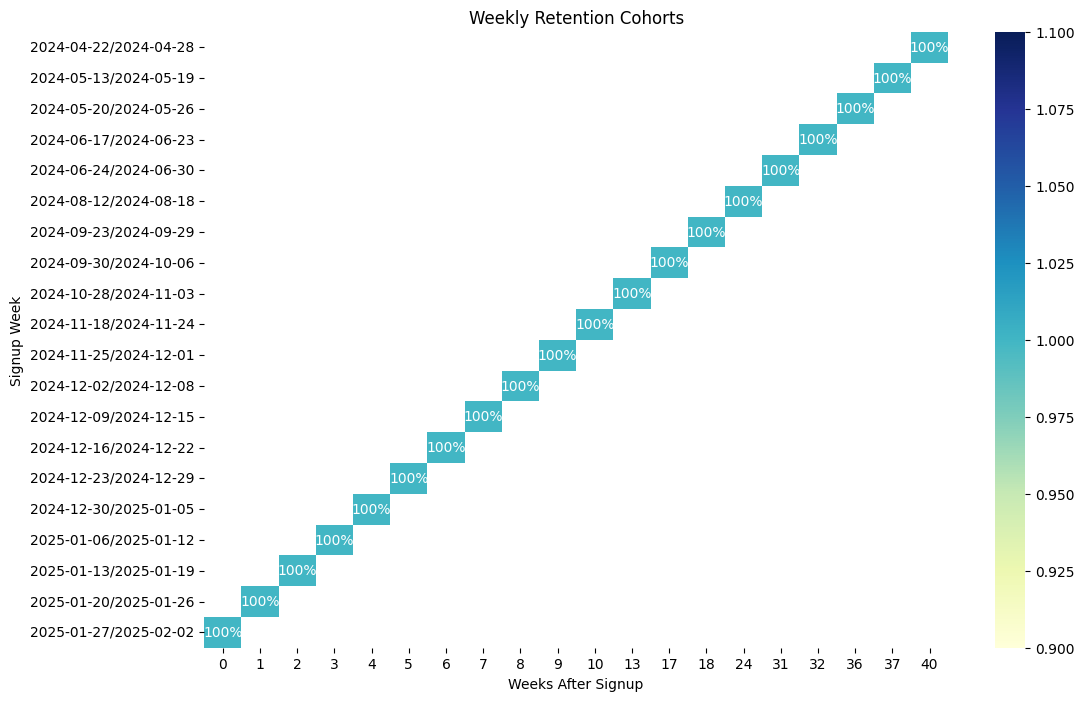

In [38]:
# Assign each user to a signup cohort based on their first recorded event week.
processed_data['signup_week'] = processed_data.groupby('user_id')['event_time'].transform('min').dt.to_period('W')

# Get the current latest event week in the dataset.
current_week = processed_data['event_time'].max().to_period('W')

# Compute the first and last event time for each user within their signup cohort.
cohort_data = processed_data.groupby(['signup_week', 'user_id'])['event_time'].agg(['min', 'max'])

# Calculate how many weeks each user remained active since signup.
cohort_data['weeks_active'] = (current_week - cohort_data['min'].dt.to_period('W')).apply(lambda x: x.n)

# Create a retention matrix showing the percentage of users active in each subsequent week after signup.
retention_matrix = cohort_data.groupby('signup_week')['weeks_active'].value_counts(normalize=True).unstack()

# Plot the retention matrix as a heatmap.
plt.figure(figsize=(12,8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Weekly Retention Cohorts')
plt.ylabel('Signup Week')
plt.xlabel('Weeks After Signup')
plt.savefig('Weekly_Retention_Cohorts.png', bbox_inches='tight')
plt.show()

### THE PLOT below shows that people are only active in their signup week

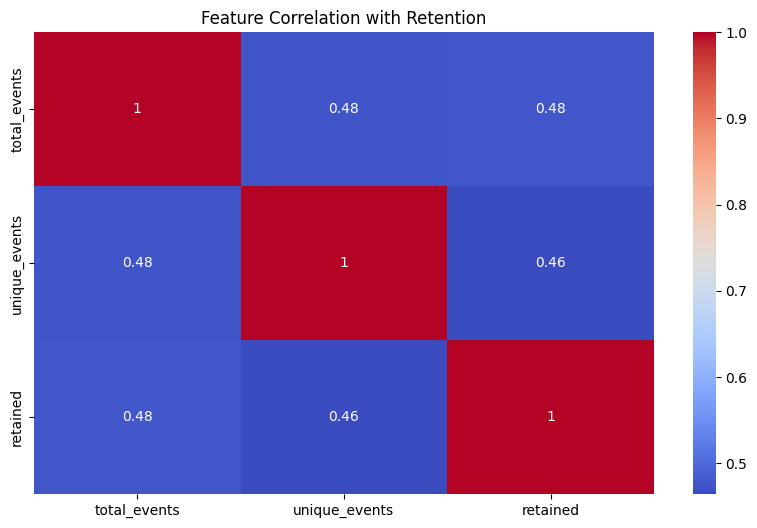

In [39]:
# Group the data by user and compute key metrics per user.
user_activity = processed_data.groupby('user_id').agg(
    total_events=('event_type', 'count'),     # Total number of events per user.
    unique_events=('event_type', 'nunique'),    # Number of distinct event types per user.
    last_active=('event_time', 'max')           # The most recent event time for each user.
).reset_index()

# Determine the cutoff for retention: users active within the last 30 days.
retention_cutoff = pd.Timestamp.now() - pd.Timedelta(days=30)
# Label users as 'retained' (1) if they were active after the cutoff, else 0.
user_activity['retained'] = (user_activity['last_active'] > retention_cutoff).astype(int)

# Plot a heatmap showing the correlation between total events, unique events, and retention status
plt.figure(figsize=(10,6))
sns.heatmap(user_activity[['total_events', 'unique_events', 'retained']].corr(), 
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Retention')
plt.savefig('Feature_Correlation_with_Retention.png', bbox_inches='tight')

plt.show()

### We only care about non-diagonal / non-red features. This graph shows that there is a good correlation between the various pairs of features

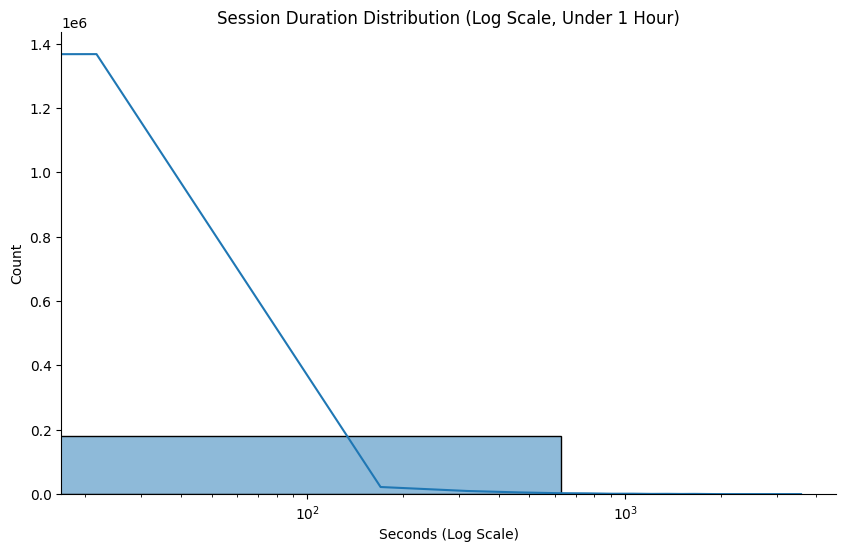

In [40]:
# Plot session duration distribution for sessions under 1 hour with a log-scaled x-axis.
plt.figure(figsize=(10,6))
sns.histplot(processed_data[processed_data['session_duration'] < 3600]['session_duration'], 
             bins=30, kde=True)  # Histogram with KDE for session durations under 3600 seconds.
plt.xscale('log')  # Apply logarithmic scaling on the x-axis for better visibility of short durations.
plt.title('Session Duration Distribution (Log Scale, Under 1 Hour)')
plt.xlabel('Seconds (Log Scale)')
sns.despine(top=True)  # Remove the top border for a cleaner look.
plt.savefig('Session_Duration_Distribution.png', bbox_inches='tight')

plt.show()

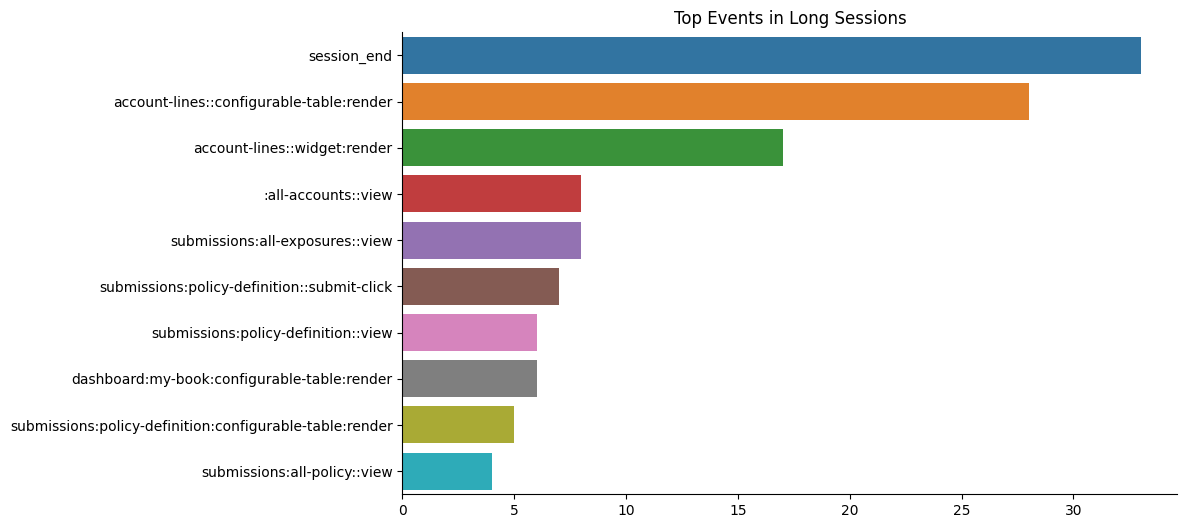

In [41]:
# Identify top event types in long sessions (over 30 minutes).
long_sessions = processed_data[processed_data['session_duration'] > 1800]  # Filter sessions longer than 1800 seconds.
top_events = long_sessions['event_type'].value_counts().nlargest(10)  # Get the 10 most frequent event types.

# Plot a horizontal bar chart for the top events in long sessions.
plt.figure(figsize=(10,6))
sns.barplot(x=top_events.values, y=top_events.index)
plt.title('Top Events in Long Sessions')
sns.despine(top=True)  # Remove the top border for a cleaner look.
plt.savefig('Top_Events_in_Long_Sessions.png', bbox_inches='tight')

plt.show()

### High Power Node Analysis

In [42]:
# Create action to index mapping
action_feat = "event_type"
action_vals = processed_data[action_feat].dropna().astype(str).unique().tolist()
action_to_idx = {val: idx for idx, val in enumerate(action_vals)}

In [43]:
str(action_vals)

"['session_end', 'session_start', 'action-center:::view', 'action-center:::submit-click', 'action-center:action-details::view', 'action-center:::close-click', 'application-window-opened', 'dashboard:my-book::view', 'dashboard:my-book:layout:render', 'dashboard:my-book:widget:render', 'dashboard:my-book:configurable-table:render', ':all-accounts:configurable-table:render', ':all-accounts:widget:render', ':all-accounts:layout:render', ':all-accounts::view', 'account-lines::layout:render', 'account-lines:::view', 'account:::view', 'account-lines::widget:render', 'account-lines::configurable-table:render', '::nav-header:action-center-click', 'action-center:action-details:response-form:submit-click', 'dashboard:my-book::action-click', 'dashboard:portfolio-insights:layout:render', 'dashboard:portfolio-insights::view', 'dashboard:portfolio-insights:widget:render', 'submissions:all-ingest_policy_through_pd:configurable-table:render', 'submissions:all-ingest_policy_through_pd::view', 'submissio

In [44]:
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

min_count = 4000
frequent_events = processed_data['event_type'].value_counts()[lambda x: x >= min_count].index.tolist()

# Filter your data accordingly:
filtered_data = processed_data[processed_data['event_type'].isin(frequent_events)]

# Group each user's events into a list from filtered data
sequences = filtered_data.groupby('user_id')['event_type'].apply(list)

# Count transitions between consecutive events
transition_counts = defaultdict(int)
for seq in sequences:
    for a, b in pairwise(seq):
        transition_counts[(a, b)] += 1

# Build directed graph using transition counts as weights
G = nx.DiGraph()
for (a, b), count in transition_counts.items():
    G.add_edge(a, b, weight=count)

node_likelihood = {}
for node in G.nodes():
    out_edges = list(G.out_edges(node, data=True))
    total = sum(data['weight'] for _, _, data in out_edges)
    if total > 0:
        max_edge = max(out_edges, key=lambda x: x[2]['weight'])
        prob = max_edge[2]['weight'] / total  # probability (0-1)
        node_likelihood[node] = prob
    else:
        node_likelihood[node] = None  # no outgoing transitions

# Use spring layout with increased spacing (adjust k parameter as needed)
pos = nx.spring_layout(G, seed=42, k=10)

node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    if node_likelihood[node] is not None:
        text = f"{node}<br>Max transition: {node_likelihood[node]*100:.1f}%"
    else:
        text = f"{node}<br>No outgoing"
    node_text.append(text)

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    marker=dict(
        size=20,
        color='LightSkyBlue',
        line=dict(width=2)
    )
)

arrow_annotations = []
for u, v, data in G.edges(data=True):
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    arrow_annotations.append(
        dict(
            x=x1, y=y1,
            ax=x0, ay=y0,
            xref="x", yref="y",
            axref="x", ayref="y",
            showarrow=True,
            arrowhead=3,
            arrowsize=1,
            arrowwidth=1,
            arrowcolor="gray",
            opacity=0.6
        )
    )

fig = go.Figure(data=[node_trace])
fig.update_layout(
    title="Filtered Event Flowchart with Likeliest Transition Percentages",
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    annotations=arrow_annotations,
    plot_bgcolor="white"
)

# Save the figure as JSON
fig_json = fig.to_json()
with open("Filtered_Event_Flowchart_with_Likeliest_Transition_Percentages.json", "w") as f:
    f.write(fig_json)
fig.show()


In [45]:
# Build event co-occurrence matrix (using a helper function "pairwise")
event_pairs = processed_data.groupby('user_id')['event_type'].apply(
    lambda x: list(pairwise(x.dropna().unique()))
)

# Build the directed graph from event pairs
G = nx.DiGraph()
for path in event_pairs:
    for a, b in pairwise(path):
        G.add_edge(a, b, weight=G.get_edge_data(a, b, default={'weight':0})['weight'] + 1)

# Calculate centrality measures
betweenness = nx.betweenness_centrality(G, weight='weight')
pagerank = nx.pagerank(G, weight='weight')

# Create a DataFrame with the results
centrality_df = pd.DataFrame({
    'event': list(pagerank.keys()),
    'pagerank': list(pagerank.values()),
    'betweenness': [betweenness[e] for e in pagerank.keys()]
})

# Normalize the centrality values (if desired)
scaler = MinMaxScaler()
centrality_df[['pagerank_norm', 'betweenness_norm']] = scaler.fit_transform(
    centrality_df[['pagerank', 'betweenness']]
)

In [46]:
# --- Filter High Power Nodes ---
# Define percentile thresholds (e.g., top 20% = 80th percentile)
TOP_PAGERANK_PCT = 95
TOP_BETWEENNESS_PCT = 95

pagerank_cutoff = np.percentile(centrality_df['pagerank'], TOP_PAGERANK_PCT)
betweenness_cutoff = np.percentile(centrality_df['betweenness'], TOP_BETWEENNESS_PCT)

# Filter nodes that exceed both thresholds
power_nodes = centrality_df[
    (centrality_df['pagerank'] >= pagerank_cutoff) &
    (centrality_df['betweenness'] >= betweenness_cutoff)
]

print("High Power Nodes:")
print(power_nodes[['event', 'pagerank', 'betweenness']])

High Power Nodes:
                                                 event  pagerank  betweenness
0                         (session_end, session_start)  0.014871     0.135008
3    (action-center:::submit-click, action-center:a...  0.009414     0.028051
4    (action-center:action-details::view, action-ce...  0.007990     0.038060
9    (dashboard:my-book:widget:render, dashboard:my...  0.017806     0.104893
10   (:all-accounts:configurable-table:render, :all...  0.020434     0.120773
12   (:all-accounts:layout:render, :all-accounts::v...  0.024359     0.165568
14   (account-lines::layout:render, account-lines::...  0.029337     0.048761
17   (account-lines::widget:render, account-lines::...  0.023577     0.113950
20   (::nav-header:action-center-click, action-cent...  0.021055     0.170149
27   (dashboard:my-book:layout:render, dashboard:my...  0.020897     0.236070
32   (dashboard:portfolio-insights:layout:render, d...  0.005536     0.039860
44      (account:::view, account-lines::layout

### Casual Inference

In [47]:
causal_df = df.copy()
causal_df['event_time'] = pd.to_datetime(causal_df['event_time'])
# Define analysis date as the maximum event time
analysis_date = causal_df['event_time'].max()

# Aggregate per user: first_seen, last_seen, total_events (a proxy for engagement)
user_history = causal_df.groupby('user_id').agg(
    first_seen=('event_time', 'min'),
    last_seen=('event_time', 'max'),
    total_events=('event_type', 'count')
).reset_index()

# Calculate observation period (in days) if needed
user_history['observation_days'] = (analysis_date - user_history['first_seen']).dt.days

# In this dataset, since nearly all users are active (100% retention), we use total_events as a proxy for retention/engagement.
user_history['engagement'] = user_history['total_events']

print("User-level summary:")
print(user_history.head())

# -------------------------------
# 3. Identify Top Events & Generate Event Indicators
# -------------------------------
# Identify the top 10 events by frequency
top_events = causal_df['event_type'].value_counts().nlargest(10)
print("Top Events by Frequency:\n", top_events)

# For each top event, create a binary indicator for whether a user performed it
user_events = causal_df.groupby('user_id')['event_type'].unique().reset_index()
for event in top_events.index:
    user_events[f'did_{event}'] = user_events['event_type'].apply(lambda events: int(event in events))

# Merge these event indicators into the user_history DataFrame
user_history = user_history.merge(user_events.drop(columns=['event_type']), on='user_id', how='left')
print("User history with event indicators:")
print(user_history.head())

# Use all did_ columns as covariates
covariate_cols = [col for col in user_history.columns if col.startswith("did_")]

# Prepare the design matrix X and outcome y (engagement)
X = user_history[covariate_cols].fillna(0)
y = user_history['engagement']

# Optionally standardize predictors or leave as-is
X = sm.add_constant(X)  # adds an intercept

# Fit an OLS model to estimate the effect of each user action on engagement
model = sm.OLS(y, X).fit()
print(model.summary())

# Extract coefficients for the event indicators and compute p-values
coef_df = pd.DataFrame({
    'event': covariate_cols,
    'coef': model.params[covariate_cols],
    'p_value': model.pvalues[covariate_cols]
}).sort_values('coef', ascending=False)

print("Estimated Effects (Odds Ratios Proxy):")
print(coef_df)

plt.figure(figsize=(10,6))
sns.barplot(x='coef', y='event', data=coef_df, hue='event', palette='viridis', dodge=False, legend=False)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Estimated Effect of User Actions on Engagement\n(Proxy for Retention)')
plt.xlabel('Coefficient (Increase in Total Events)')
plt.savefig('Estimated_Effect_of_User_Actions_on_Engagement.png', bbox_inches='tight')

plt.show()



User-level summary:
                                user_id              first_seen  \
0  00edf9a8-949a-415d-8ed2-ae04b8f4d326 2025-01-02 15:02:33.007   
1  012562f9-1ca0-4a82-8a47-0c4f5d6db7bb 2025-01-02 22:00:45.026   
2  0137eb6b-c710-46f5-8667-b0669339d5ef 2024-12-19 20:04:41.516   
3  01708ccf-437b-44ed-b5a0-2fed8f7761d3 2025-01-02 16:05:55.550   
4  024e0855-dc2f-42cf-9209-93f3ea5f99d0 2024-12-20 20:58:29.901   

                last_seen  total_events  observation_days  engagement  
0 2025-01-28 14:35:49.660            76                26          76  
1 2025-01-28 18:46:16.279           840                25         840  
2 2025-01-02 16:12:26.978            11                39          11  
3 2025-01-28 14:33:27.723          1114                26        1114  
4 2025-01-17 17:51:01.702            89                38          89  
Top Events by Frequency:
 account-lines::widget:render                   44168
account-lines::configurable-table:render       26420
account-lines

NameError: name 'sm' is not defined

### Prediction Guy Modelling

In [55]:
# Convert event_time to datetime and sort
df['event_time'] = pd.to_datetime(df['event_time'])
df.sort_values(by=['session_id', 'event_time'], inplace=True)  # Changed to session_id

In [56]:
# Group by session_id instead of user_id
session_groups = df.groupby('session_id')

In [57]:
features = [
    "city", "client_event_time", "client_upload_time", "country", "data_type",
    "device_family", "device_type", "language", "event_type", "os_name", "os_version",
    "platform", "region", "event_properties_type", "event_properties_line-of-business",
    "event_properties_accountId", "event_properties_status", "event_properties_lineOfBusiness",
    "event_properties_action", "event_properties_error", "event_properties_templateName",
    "event_properties_hasAssignees", "event_properties_hasAccounts", "event_properties_displayName",
    "event_properties_variant", "event_properties_tableId", "event_properties_menu",
    "event_properties_filename", "event_properties_attachmentId", "user_properties_isInternalUser",
    "user_properties_roles", "user_properties_referring_domain", "user_properties_businessUnit",
    "user_properties_hostname"
]
print(len(features))

34


In [58]:
# Create index mappings for each feature (modified for list handling)
feature_to_idx = {}

for feat in features:
    if feat == 'user_properties_roles':
        # Handle list values by taking first role
        unique_vals = (
            df[feat]
            .dropna()
            .apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
            .dropna()
            .astype(str)
            .unique()
            .tolist()
        )
    else:
        unique_vals = df[feat].dropna().astype(str).unique().tolist()
    
    # Create mapping with default index 0
    idx_map = {'__default__': 0}
    current_idx = 1
    for val in unique_vals:
        key = str(val)
        if key not in idx_map:
            idx_map[key] = current_idx
            current_idx += 1
    feature_to_idx[feat] = idx_map

In [59]:
feature_to_idx['user_properties_roles']

{'__default__': 0,
 'underwriter': 1,
 'admin': 2,
 'agent': 3,
 'System Admin': 4,
 'Broker': 5,
 'manager': 6,
 'Broker View-only': 7,
 'Underwriter': 8,
 'Leader': 9,
 'System Manager': 10,
 'executive': 11,
 'FS': 12}

In [60]:
# Process data into indices (with error handling)
concatenated_sequences = {}

for session_id, group in session_groups:  # Now using session_id
    group_sorted = group.sort_values(by='event_time')
    event_indices = []
    
    for _, row in group_sorted.iterrows():
        indices = []
        for feat in features:
            val = row[feat]
            
            # Handle null/empty values
            if isinstance(val, (list, np.ndarray)):
                
                # Handle empty lists/arrays
                if len(val) == 0:
                    indices.append(0)
                    continue
                
                # Special handling for user_properties_roles
                if feat == 'user_properties_roles':
                    # Take first role if available
                    val = val[0] if len(val) > 0 else np.nan
                else:
                    # Convert list to string representation
                    val = str(val)
            
            elif pd.isnull(val):
                indices.append(0)
                continue
            else:
                val = str(val)
            
            # Get index from mapping
            idx = feature_to_idx[feat].get(val, 0)
            indices.append(idx)
        
        event_indices.append(torch.tensor(indices, dtype=torch.long))
    
    if event_indices:
        concatenated_sequences[session_id] = event_indices
print(len(concatenated_sequences))

8931


In [61]:
# Set the window size and maximum examples
time_steps = 8
max_examples = 133713371337

# Create action to index mapping
action_feat = "event_type"
action_vals = df[action_feat].dropna().astype(str).unique().tolist()
action_to_idx = {val: idx for idx, val in enumerate(action_vals)}

# Initialize lists to store the examples and labels
X_examples = []
y_examples = []

too_short_count = 0
invalid_label_count = 0
total_sessions = len(concatenated_sequences)

for session_id, events in concatenated_sequences.items():
    if len(events) <= time_steps:
        too_short_count += 1
        continue  # Skip too short sessions
    
    session_df = df[df['session_id'] == session_id].sort_values(by='event_time')
    
    for i in range(len(events) - time_steps):
        window = events[i:i + time_steps]
        example = torch.stack(window)  # shape: (time_steps, hidden_size)
        
        target_row = session_df.iloc[i + time_steps]
        if pd.isnull(target_row[action_feat]):
            invalid_label_count += 1
            continue  # Skip missing labels
        
        target_val = str(target_row[action_feat])
        if target_val not in action_to_idx:
            invalid_label_count += 1
            continue  # Skip unknown labels
        
        label_idx = action_to_idx[target_val]
        
        X_examples.append(example)
        y_examples.append(label_idx)
        
        if len(X_examples) >= max_examples:
            break
    if len(X_examples) >= max_examples:
        break

# Print debugging info
print(f"Total sessions: {total_sessions}")
print(f"Too short sessions (≤{time_steps}): {too_short_count}")
print(f"Invalid or missing labels: {invalid_label_count}")
print(f"Valid examples collected: {len(X_examples)}")

Total sessions: 8931
Too short sessions (≤8): 5373
Invalid or missing labels: 0
Valid examples collected: 151527


In [62]:
str(action_vals)

"['session_end', 'application-window-opened', 'session_start', 'agency-dashboard::layout:render', 'agency-dashboard:::view', 'agency-dashboard::widget:render', 'agency-dashboard::configurable-table:render', '::nav-header:user-signed-out', 'dashboard:my-book:configurable-table:render', 'dashboard:my-book:widget:render', 'triaged-submission-list:my-book:configurable-table:render', 'triaged-submission-list:my-book::view', 'dashboard:my-book:layout:render', 'dashboard:my-book::view', '::nav-header:action-center-click', 'action-center:::view', 'account:::view', 'account-lines:::view', 'account-lines::layout:render', 'account-lines::widget:render', 'account-lines::configurable-table:render', ':all-accounts:configurable-table:render', ':all-accounts:widget:render', ':all-accounts:layout:render', ':all-accounts::view', 'submissions:policy-definition::submit-click', 'submissions:all-policy:configurable-table:render', 'submissions:all-policy::view', 'submissions:triaged_submissions-definition::v

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_all = torch.stack(X_examples) # (num_examples, time_steps, 34)
y_all = torch.tensor(y_examples, dtype=torch.long)

In [64]:
print(X_all.shape)
print(y_all.shape)

torch.Size([151527, 8, 34])
torch.Size([151527])


In [65]:
# Train/val/test split
num_examples = len(X_examples)
indices = torch.randperm(num_examples)

train_idx = indices[:int(0.8*num_examples)]
val_idx = indices[int(0.8*num_examples):int(0.9*num_examples)]
test_idx = indices[int(0.9*num_examples):]

X_train, y_train = X_all[train_idx], y_all[train_idx]
X_val, y_val = X_all[val_idx], y_all[val_idx]
X_test, y_test = X_all[test_idx], y_all[test_idx]

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: torch.Size([121221, 8, 34])
Validation set: torch.Size([15153, 8, 34])
Test set: torch.Size([15153, 8, 34])


In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, feature_sizes, embedding_dim=64, hidden_size=128, dropout=0.5):
        super().__init__()
        # Create an embedding for each feature
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=size, embedding_dim=embedding_dim)
            for size in feature_sizes
        ])
        
        # Dropout module for regularization
        self.dropout = nn.Dropout(dropout)
        
        # First LSTM layer: input is concatenated embeddings
        self.lstm1 = nn.LSTM(
            input_size=embedding_dim * len(feature_sizes),
            hidden_size=hidden_size,
            batch_first=True
        )
        # A linear projection to match the dimensions for the first residual connection
        self.residual_proj1 = nn.Linear(embedding_dim * len(feature_sizes), hidden_size)
        
        # Second LSTM layer: input and output are both hidden_size
        self.lstm2 = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        
        # Activation function
        self.activation = nn.ReLU()
        
        # Final fully-connected layer to produce logits over actions
        self.fc = nn.Linear(hidden_size, len(action_to_idx))
        
    def forward(self, x):
        # x shape: (batch_size, time_steps, num_features)
        batch_size, seq_len, num_feats = x.size()
        
        # Process each feature through its embedding
        embedded = []
        for i in range(num_feats):
            emb = self.embeddings[i](x[:, :, i])  # (batch_size, seq_len, embedding_dim)
            embedded.append(emb)
        x_emb = torch.cat(embedded, dim=-1)  # (batch_size, seq_len, embedding_dim*num_feats)
        x_emb = self.dropout(x_emb)
        
        # First LSTM layer
        out1, _ = self.lstm1(x_emb)  # (batch_size, seq_len, hidden_size)
        # Residual: project input embeddings and add to LSTM output
        res1 = self.residual_proj1(x_emb)  # (batch_size, seq_len, hidden_size)
        out1 = self.activation(out1 + res1)
        out1 = self.dropout(out1)
        
        # Second LSTM layer
        out2, _ = self.lstm2(out1)  # (batch_size, seq_len, hidden_size)
        # Residual: add the output of the first LSTM layer (out1) to the output of the second
        out2 = self.activation(out2 + out1)
        out2 = self.dropout(out2)
        
        # Use the output of the final time step for prediction
        logits = self.fc(out2[:, -1, :])  # (batch_size, num_actions)
        return logits


In [91]:
# Initialize model
feature_sizes = [len(feature_to_idx[feat]) for feat in features]
model = LSTM(feature_sizes).to(device)

In [92]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params / 1e6:.2f}M")

Total parameters: 16.13M


In [93]:
# Create dataloaders
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val, y_val, )
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss/len(train_loader.dataset):.4f}")
    print(f"Val Loss: {val_loss/len(val_loader.dataset):.4f}")
    print(f"Val Acc: {100*correct/total:.2f}%")
    print("-------------------")

Epoch 1/10
Train Loss: 2.0297
Val Loss: 1.3553
Val Acc: 59.68%
-------------------
Epoch 2/10
Train Loss: 1.4576
Val Loss: 1.0909
Val Acc: 68.71%
-------------------
Epoch 3/10
Train Loss: 1.2817
Val Loss: 0.9761
Val Acc: 71.77%
-------------------
Epoch 4/10
Train Loss: 1.1749
Val Loss: 0.8658
Val Acc: 75.32%
-------------------
Epoch 5/10
Train Loss: 1.1016
Val Loss: 0.8110
Val Acc: 76.80%
-------------------
Epoch 6/10
Train Loss: 1.0475
Val Loss: 0.7801
Val Acc: 77.70%
-------------------


In [ ]:
# Test evaluation
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f"Test Loss: {test_loss/len(test_loader.dataset):.4f}")
print(f"Test Acc: {100*correct/total:.2f}%")